# Experiment 5
Apply transfer learning to MobileNetV2 (trained on ImageNet) with data augmentation

In [1]:
# model training using tensorflow
import numpy as np
import os
import cv2
from matplotlib import pyplot

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
'''
Configuration Code
'''
def get_n_cores():
    """The NSLOTS variable, If NSLOTS is not defined throw an exception."""
    nslots = os.getenv("NSLOTS")
    if nslots is not None:
        return int(nslots)
    raise ValueError("Environment variable NSLOTS is not defined.")


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

NUM_GPUS = len(tf.config.experimental.list_physical_devices("GPU"))
print("Num GPUs Available: ", NUM_GPUS)
if NUM_GPUS > 0:
    print(os.getenv("CUDA_VISIBLE_DEVICES"))

tf.config.set_soft_device_placement(True)
tf.keras.backend.set_floatx("float32")
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(get_n_cores())

Num GPUs Available:  1
1


In [3]:
batch_size = 32

DATA_DIRECTORY = os.path.join(os.getcwd(), 'data', 'formatted_data')

size = (224,224) # height, width

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIRECTORY,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=size,
  batch_size=batch_size
)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIRECTORY,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=size,
  batch_size=batch_size
)

Found 3000 files belonging to 2 classes.
Using 600 files for validation.


In [5]:
'''
Set the base model to MobileNetV2 (trained on ImageNet)
'''
IMG_SHAPE = size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [6]:
# do not allow the NN to train the base network
base_model.trainable = False

In [7]:
# create the additional layers for the end
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2)

In [8]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3))

In [9]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224,224,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [10]:
# chain the layers together to make the complete model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = normalization_layer(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
# we need a low learning rate to avoid overfitting
base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [15]:
epochs=100

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/100
75/75 [==============================] - 6s 80ms/step - loss: 0.9088 - accuracy: 0.5188 - val_loss: 0.6832 - val_accuracy: 0.5850
Epoch 2/100
75/75 [==============================] - 5s 69ms/step - loss: 0.6774 - accuracy: 0.6263 - val_loss: 0.5601 - val_accuracy: 0.7233
Epoch 3/100
75/75 [==============================] - 5s 68ms/step - loss: 0.5874 - accuracy: 0.6804 - val_loss: 0.4775 - val_accuracy: 0.8150
Epoch 4/100
75/75 [==============================] - 5s 69ms/step - loss: 0.5258 - accuracy: 0.7404 - val_loss: 0.4234 - val_accuracy: 0.8333
Epoch 5/100
75/75 [==============================] - 5s 68ms/step - loss: 0.4713 - accuracy: 0.7808 - val_loss: 0.3881 - val_accuracy: 0.8550
Epoch 6/100
75/75 [==============================] - 5s 70ms/step - loss: 0.4359 - accuracy: 0.8037 - val_loss: 0.3617 - val_accuracy: 0.8683
Epoch 7/100
75/75 [==============================] - 5s 68ms/step - loss: 0.4051 - accuracy: 0.8233 - val_loss: 0.3429 - val_accuracy: 0.8700
Epoch 

75/75 [==============================] - 5s 66ms/step - loss: 0.1696 - accuracy: 0.9329 - val_loss: 0.1756 - val_accuracy: 0.9350
Epoch 59/100
75/75 [==============================] - 5s 66ms/step - loss: 0.1724 - accuracy: 0.9417 - val_loss: 0.1738 - val_accuracy: 0.9350
Epoch 60/100
75/75 [==============================] - 5s 67ms/step - loss: 0.1740 - accuracy: 0.9392 - val_loss: 0.1789 - val_accuracy: 0.9400
Epoch 61/100
75/75 [==============================] - 5s 67ms/step - loss: 0.1670 - accuracy: 0.9383 - val_loss: 0.1719 - val_accuracy: 0.9367
Epoch 62/100
75/75 [==============================] - 5s 65ms/step - loss: 0.1670 - accuracy: 0.9367 - val_loss: 0.1711 - val_accuracy: 0.9383
Epoch 63/100
75/75 [==============================] - 5s 63ms/step - loss: 0.1516 - accuracy: 0.9500 - val_loss: 0.1695 - val_accuracy: 0.9400
Epoch 64/100
75/75 [==============================] - 5s 65ms/step - loss: 0.1617 - accuracy: 0.9429 - val_loss: 0.1703 - val_accuracy: 0.9383
Epoch 65/100

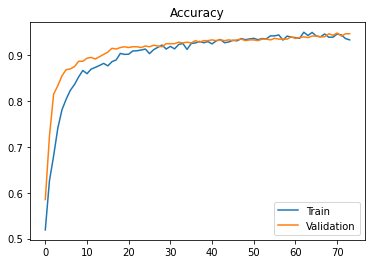

In [17]:
'''
Plot the accuracy
'''
pyplot.title("Accuracy")
pyplot.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label = "Train")
pyplot.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label = "Validation")
pyplot.legend()
pyplot.show()

In [18]:
# save the model
model.save("models/{}".format("experiment_005a"))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: models/experiment_005a/assets


INFO:tensorflow:Assets written to: models/experiment_005a/assets


Fine-tuning can hopefully improve the model still. The last 50 layers of MobileNetV2 will be unlocked to allow for gradient adjustments

In [21]:
# change to fine tuning
base_model.trainable = True

# this is the layer to start fine tuning at
fine_tune_at = len(base_model.layers) - 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [22]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/100),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                

In [24]:
fine_tune_epochs = 100
total_epochs =  history.epoch[-1] + fine_tune_epochs

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    callbacks = [callback]
)


Epoch 74/173
75/75 [==============================] - 6s 81ms/step - loss: 0.1421 - accuracy: 0.9492 - val_loss: 0.1565 - val_accuracy: 0.9500
Epoch 75/173
75/75 [==============================] - 5s 71ms/step - loss: 0.1329 - accuracy: 0.9500 - val_loss: 0.1457 - val_accuracy: 0.9517
Epoch 76/173
75/75 [==============================] - 5s 72ms/step - loss: 0.1313 - accuracy: 0.9513 - val_loss: 0.1389 - val_accuracy: 0.9483
Epoch 77/173
75/75 [==============================] - 5s 72ms/step - loss: 0.1231 - accuracy: 0.9529 - val_loss: 0.1329 - val_accuracy: 0.9517
Epoch 78/173
75/75 [==============================] - 5s 72ms/step - loss: 0.1247 - accuracy: 0.9542 - val_loss: 0.1325 - val_accuracy: 0.9533
Epoch 79/173
75/75 [==============================] - 7s 94ms/step - loss: 0.1127 - accuracy: 0.9567 - val_loss: 0.1296 - val_accuracy: 0.9517
Epoch 80/173
75/75 [==============================] - 6s 77ms/step - loss: 0.1073 - accuracy: 0.9613 - val_loss: 0.1316 - val_accuracy: 0.9533

75/75 [==============================] - 5s 66ms/step - loss: 0.0359 - accuracy: 0.9862 - val_loss: 0.0883 - val_accuracy: 0.9683
Epoch 132/173
75/75 [==============================] - 5s 67ms/step - loss: 0.0308 - accuracy: 0.9887 - val_loss: 0.0775 - val_accuracy: 0.9783
Epoch 133/173
75/75 [==============================] - 5s 66ms/step - loss: 0.0344 - accuracy: 0.9879 - val_loss: 0.0854 - val_accuracy: 0.9700
Epoch 134/173
75/75 [==============================] - 5s 67ms/step - loss: 0.0289 - accuracy: 0.9917 - val_loss: 0.0854 - val_accuracy: 0.9700
Epoch 135/173
75/75 [==============================] - 5s 67ms/step - loss: 0.0331 - accuracy: 0.9879 - val_loss: 0.0818 - val_accuracy: 0.9733
Epoch 136/173
75/75 [==============================] - 5s 67ms/step - loss: 0.0364 - accuracy: 0.9862 - val_loss: 0.0873 - val_accuracy: 0.9700
Epoch 137/173
75/75 [==============================] - 5s 66ms/step - loss: 0.0361 - accuracy: 0.9887 - val_loss: 0.0850 - val_accuracy: 0.9700
Epoch 

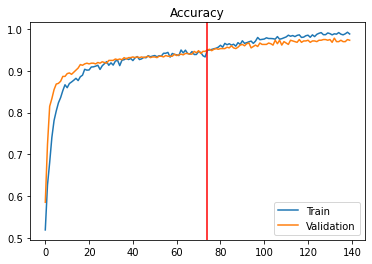

In [31]:
'''
Plot the total accuracy
'''
n = len(history.history['accuracy']) + len(history_fine.history['accuracy'])

pyplot.title("Accuracy")
pyplot.plot(range(n), history.history['accuracy'] + history_fine.history['accuracy'], label = "Train")
pyplot.plot(range(n), history.history['val_accuracy'] + history_fine.history['val_accuracy'], label = "Validation")

pyplot.axvline(x=len(history.history['loss']), color='red')
pyplot.legend()
pyplot.show()


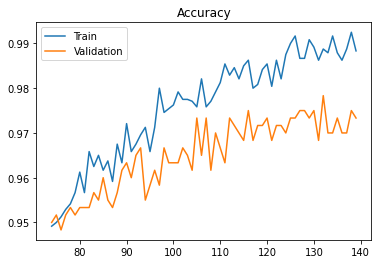

In [32]:
'''
Plot the fine tuning accuracy
'''
a = len(history.history['accuracy'])
b = len(history_fine.history['accuracy'])
c = a+b

pyplot.title("Accuracy")
pyplot.plot(range(a,c), history_fine.history['accuracy'], label = "Train")
pyplot.plot(range(a,c), history_fine.history['val_accuracy'], label = "Validation")
pyplot.legend()
pyplot.show()


In [33]:
model.save('models/experiment_005b')

INFO:tensorflow:Assets written to: models/experiment_005b/assets


INFO:tensorflow:Assets written to: models/experiment_005b/assets
